**This file predicts drug-drug interaction using protein-drug models**

In this file, we
1. read in drugs of interest, target of interest
2. generate drug-protein interaction model from bindingbd/davis/other dataset
3. use the model to predict target drug-target protein interaction
4. store the interaction as features for each drug
5. Use the features to predict drug-drug interaction

**Connect to Colab environment, import packages**

In [1]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'DeepPurpose')
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

Mounted at /content/drive
['data']


In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import torch

**Step 1: Prepare drug-target interaction pair/dataframes from drug files and target files, used for step2 prediction**

Specify the below dataset:
1. **drug_dataset_path**: drugs of interest with encoding (here we need a file containing drug SMILES and corresponding *drug_encoding* we want to use)<br/>
eg. Indigo drug dataset, brochado drug dataset
2. **target_protein_dataset_path**: target of interest with encoding (here we need a file containing protein sequence and corresponding *target_encoding* we want to use)<br/>
eg. all ecoli proteins from string dataset(ecoli4087)





In [5]:
# TODO: Specify below
drug_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, "data/original_MACCS_new.pkl")
target_protein_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, "data/ecoli_1421.pkl") # "ecoli_1421"
target_enc = os.path.join(GOOGLE_DRIVE_PATH, "data/target_enc_1421.xlsx")

In [6]:
target_data = pd.read_pickle(target_protein_dataset_path)
target_map = target_data.drop_duplicates(subset=['Target Sequence'])
# target_map = target_map[["Target Sequence", target_enc]]
target_map

,Target Sequence,PseudoAAC
0,MELPNIMHPVAKLSTALAAALMLSGCMPGEIRPTIGQQMETGDQRF...,"[0.082, 0.018, 0.022, 0.036, 0.004, 0.014, 0.0..."
1,MTLSFITRWRDELPATYTTLSPTPLNNARLIWHNAELANTLGIPSS...,"[0.042, 0.041, 0.016, 0.033, 0.002, 0.027, 0.0..."
2,MTQSAMCIPLWPARNGNTAHLVMCPFAGGSSSAFRHWQAEQLADCA...,"[0.054, 0.034, 0.008, 0.027, 0.015, 0.027, 0.0..."
3,MGFLRSGCYPDSCHADWYRYNLTYRQCKSGPPMAGRFVWKPDLMFK...,"[0.052, 0.019, 0.022, 0.019, 0.006, 0.017, 0.0..."
4,MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...,"[0.044, 0.031, 0.013, 0.041, 0.013, 0.036, 0.0..."
...,...,...
1420,MTVPISIIFWGNIMKKHLVVIAFCVLFASASAFAAKGTDSLKSSIE...,"[0.033, 0.007, 0.035, 0.035, 0.005, 0.023, 0.0..."
1421,MAKELSVYGPTAGESMGGTGANLNQQGGNNNSNSGVHWGGGSGSGN...,"[0.048, 0.021, 0.038, 0.037, 0.0, 0.03, 0.016,..."
1422,MNKVYNTVWNESTGTWVVTSELTRKGGLRPRQIKRTVLAGLIAGLL...,"[0.048, 0.019, 0.04, 0.031, 0.0, 0.013, 0.017,..."
1423,MAKHLFTSESVSEGHPDKIADQISDAVLDAILEQDPKARVACETYV...,"[0.05, 0.024, 0.009, 0.035, 0.005, 0.034, 0.02..."


In [31]:
# read drug dataset
# TODO: change data path
# indigo: "identifier_with_MACCS.pkl"
# NP_canosmiles: "NPshort_canosmiles_MACCS.pkl"
# NP_supersmiles: "NPshort_supersmiles_MACCS.pkl"


drug_map = pd.read_pickle(drug_dataset_path)
drug_map = drug_map.replace("TRI", "TMP")
drug_map

,Full name,docking abbrev,SMILES,MACCS
0,A22,A22,C1=CC(=C(C=C1CSC(=[NH2+])N)Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Amikacin,AMK,C1C(C(C(C(C1NC(=O)C(CCN)O)OC2C(C(C(C(O2)CO)O)N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Ampicilin,AMP,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
3,Amoxicillin,AMX,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
4,Azithromycin,AZI,CCC1C(C(C(N(CC(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Aztreonam,AZT,CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
6,Bacitracin,BAC,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Bleomycin,BLM,CC1=C(N=C(N=C1N)C(CC(=O)N)NCC(C(=O)N)N)C(=O)NC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Benzalkonium,BZK,CCCCCCCCCCCCC[N+](C)(C)CC1=CC=CC=C1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,CCCP,CCCP,C1=CC(=CC(=C1)Cl)NN=C(C#N)C#N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Create separate dataframes for each drug**


Dataframe: single drug: all targets

In [32]:
# TODO: change the names according to dataset
drug_encoding = "MACCS"
target_encoding = "PseudoAAC"
drug_identifier_name = "docking abbrev"
drug_df_arr=[]

for i in range(len(drug_map)):
  print(drug_map[drug_identifier_name][i])
  new_df = target_map.copy()
  new_df["SMILES"] = drug_map[drug_identifier_name][i]
  new_encoding = np.tile(drug_map[drug_encoding][i], (len(target_map),1))  # Copy MACCS
  new_df[drug_encoding] = new_encoding.tolist()
  new_df["drug"] = drug_map[drug_identifier_name][i]
  drug_df_arr.append(new_df)
  # path = os.path.join(GOOGLE_DRIVE_PATH, "Transformer_nemo/drugdrug/",str(i)+".pkl")
  # new_df.to_pickle(path)

A22
AMK
AMP
AMX
AZI
AZT
BAC
BLM
BZK
CCCP
CEC
CEF
CER
CFS
CHL
CIP
CLA
CSD
DOX
DXR
EGCG
ERY
FOS
FUS
GEN
GLU
GLY
H2O2
ISO
LEV
MEC
MEM
MIN
MXF
NAL
NIT
NOR
NVB
OXA
PAR
PHL
PMB
PMS
PRC
PUR
PYO
RIF
SMM
SMX
SPE
SPM
TET
TOB
TPH
TRC
TMP
VAN
VER


**Step 2: generate protein-drug interaction features**<br/>
Below code generates features for individual drugs, if feature already
generates, go to next section.

**Load data for training**<br/>
Specify below:<br/>
>**training_dataset**: known drug-protein interaction dataset with *training_drug_encoding* and *training_protein_encoding*<br/>
eg. bindingdb/davis <br/>
Ideally we keep encoding consistent between training and prediction, but naming might be different, that's why we specify both.

In [34]:
# drug_encoding = "MACCS"
# target_encoding = "PseudoAAC"
training_data_path = os.path.join(GOOGLE_DRIVE_PATH, "data/bindingdb_merged_all.pkl")
training_drug_encoding = "MACCS"
training_protein_encoding = "PseudoAAC(target)"

Generate X_train and y_train from training dataset used for training

In [35]:
def apply_func_train(x):
  try:
    return np.concatenate((x[drug_encoding],x[training_protein_encoding]))

  except:
    return "error"

def load_and_process(dataset):

  df = pd.read_pickle(training_data_path)
  df.dropna(subset=[drug_encoding,training_protein_encoding],inplace=True)
  df['combined']=df.apply(lambda x:apply_func_train(x),axis=1)
  # train_nonzero=train[train['Label']!=0]
  df = df[df['combined']!="error"]

  X=df.combined.tolist()
  y=df['Label'].tolist()
  X=np.array(X)
  y=np.array(y)
  mask=torch.tensor(y)<30
  y_binary=torch.zeros_like(torch.tensor(y))
  y_binary[mask]=1
  y_binary.tolist()
  y_binary=y_binary.reshape(y_binary.shape[0],1)
  y_binary=y_binary.tolist()
  X=np.array(X)
  y_binary=np.array(y_binary)
  y_binary = y_binary.reshape(-1)
  print(y_binary)
  return X,y_binary


X,y=load_and_process("bindingdb")

/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


[1. 1. 1. ... 0. 0. 0.]


**Train model on training dataset and predict for target drug-target protein pairs**

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import PrecisionRecallDisplay
import json

def apply_func(x):
  try:
    return np.concatenate((x[drug_encoding],x[target_encoding]))
  except:
    return "error"

mydict = {}

X_train = X
y_train = y
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
###
for test_df in drug_df_arr:
  test_df.dropna(subset=[drug_encoding,target_encoding],inplace=True)
  test_df['combined']=test_df.apply(lambda x:apply_func(x),axis=1)
  test_df = test_df[test_df['combined']!="error"]
  X_test=test_df.combined.tolist()
  X_test=np.array(X_test)
  y_pred = classifier.predict_proba(X_test)[:, 1]
  mask=torch.tensor(y_train)<0
  mydict[test_df.drug[0]]=y_pred

/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [37]:
mydict

{'A22': array([0.28 , 0.19 , 0.18 , ..., 0.306, 0.155, 0.15 ]),
 'AMK': array([0.28      , 0.15      , 0.23      , ..., 0.24      , 0.18666667,
        0.23      ]),
 'AMP': array([0.39333333, 0.305     , 0.325     , ..., 0.34333333, 0.24      ,
        0.315     ]),
 'AMX': array([0.39333333, 0.29      , 0.32      , ..., 0.35333333, 0.23      ,
        0.295     ]),
 'AZI': array([0.35      , 0.28      , 0.31857143, ..., 0.315     , 0.275     ,
        0.30366667]),
 'AZT': array([0.37833333, 0.3       , 0.30285714, ..., 0.39      , 0.20085714,
        0.26      ]),
 'BAC': array([0.24      , 0.2       , 0.18      , ..., 0.23      , 0.19      ,
        0.17714286]),
 'BLM': array([0.27      , 0.18      , 0.26      , ..., 0.325     , 0.22666667,
        0.21      ]),
 'BZK': array([0.32222222, 0.17      , 0.25257143, ..., 0.3625    , 0.16      ,
        0.21690476]),
 'CCCP': array([0.24, 0.15, 0.22, ..., 0.24, 0.12, 0.08]),
 'CEC': array([0.385     , 0.19      , 0.29166667, ..., 0.335

Additionaly you can create a binary feature using threshold of your choice

In [38]:
mydict_binary = mydict.copy()
threshold = 0.4
for key,value in mydict.items():
  mask=torch.tensor(value)>threshold
  temp=torch.zeros_like(torch.tensor(value))
  temp[mask]=1
  mydict_binary[key] = temp.tolist()

In [ ]:
#TODO: optionally you can save the dictionary for direct use next time
#with open(os.path.join(GOOGLE_DRIVE_PATH, "data/NPshort_supersmiles_1421ecoli_dictionary.pkl"), 'wb') as fp:
#    pickle.dump(mydict, fp)


**Step 3: Using drug-target features to generate drug-drug interaction  features**

**Read features for each drug**

In [39]:
# If you saved your dictionary you can load from here
#mydict=pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_mydict.pkl"))

mydict['TMP'] #Just for checking

array([0.19 , 0.11 , 0.14 , ..., 0.195, 0.09 , 0.14 ])

**Read in train and test dataset**<br/>
Specify here:
1. training_data_path: drug-drug interaction files of interest (training), contains two or more drugs and interaction score.<br/>
eg. magenta_train_scores
2. testing_data_path: drug-drug interaction files of interest (testing), contains two or more drugs and interaction score.<br/>
eg. magenta_test_scores

In [40]:
training_data_path = os.path.join(GOOGLE_DRIVE_PATH, "data/magenta_train_scores.xlsx")
testing_data_path = os.path.join(GOOGLE_DRIVE_PATH, "data/magenta_test_scores.xlsx")

In [41]:
train = pd.read_excel(training_data_path)
train = train.replace("TRI", "TMP")
test = pd.read_excel(testing_data_path)
test = test.replace("TRI", "TMP")
train

,Drug_1,Drug_2,Media,Score
0,AMK,CEF,NaN,1.373500
1,AMK,CHL,NaN,2.729500
2,AMK,CIP,NaN,-0.024000
3,AMK,CLA,NaN,-0.326000
4,AMK,ERY,NaN,1.433500
...,...,...,...,...
222,TMP,SPE,GLUCOSE,0.030442
223,TMP,TET,GLUCOSE,0.483156
224,RIF,SPE,GLUCOSE,0.061049
225,RIF,TET,GLUCOSE,-0.250495


**Calculate feature scores**
Here I use Sigma and Delta Scores

In [42]:
def sigma(x):
  try:
    return 2/3*np.add(np.add(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2]),mydict_binary[x.Media])
  except:
    return np.add(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2])

def delta(x):
  try:
    row = np.add(np.add(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2]),mydict_binary[x.Media])
    if row==1:
      return 1
    else:
      return 0
  except:
    row = abs(np.subtract(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2]))
    return row


train['feat1'] = train.apply(lambda x:mydict[x.Drug_1],axis=1)
test['feat1'] = test.apply(lambda x:mydict[x.Drug_1],axis=1)
train['feat2'] = train.apply(lambda x:mydict[x.Drug_2],axis=1)
test['feat2'] = test.apply(lambda x:mydict[x.Drug_2],axis=1)
train['sigma'] = train.apply(lambda x:sigma(x),axis=1)
test['sigma'] = test.apply(lambda x:sigma(x),axis=1)
train['delta'] = train.apply(lambda x:delta(x),axis=1)
test['delta'] = test.apply(lambda x:delta(x),axis=1)

train

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta
0,AMK,CEF,NaN,1.373500,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2823333333333333, 0.2, 0.26275, 0.29, 0.21,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,CHL,NaN,2.729500,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2526666666666666, 0.11, 0.19, 0.22, 0.25, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,AMK,CIP,NaN,-0.024000,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.29, 0.16, 0.2, 0.2866666666666666, 0.3325, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,AMK,CLA,NaN,-0.326000,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.28, 0.19, 0.3119047619047619, 0.33399999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,ERY,NaN,1.433500,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.29, 0.23, 0.2985714285714286, 0.33399999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
222,TMP,SPE,GLUCOSE,0.030442,"[0.19, 0.11, 0.14, 0.2425, 0.13, 0.27, 0.22, 0...","[0.3, 0.134, 0.22857142857142856, 0.27, 0.2233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
223,TMP,TET,GLUCOSE,0.483156,"[0.19, 0.11, 0.14, 0.2425, 0.13, 0.27, 0.22, 0...","[0.35, 0.32, 0.29, 0.39, 0.34583333333333327, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
224,RIF,SPE,GLUCOSE,0.061049,"[0.34, 0.24, 0.23, 0.33333333333333326, 0.2911...","[0.3, 0.134, 0.22857142857142856, 0.27, 0.2233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
225,RIF,TET,GLUCOSE,-0.250495,"[0.34, 0.24, 0.23, 0.33333333333333326, 0.2911...","[0.35, 0.32, 0.29, 0.39, 0.34583333333333327, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [43]:
test

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta
0,AMK,AMP,GLYCEROL,-0.822900,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.39333333333333337, 0.305, 0.325, 0.32, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,AZI,GLYCEROL,0.565743,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.35, 0.28, 0.31857142857142856, 0.29, 0.37, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,AMK,AZT,GLYCEROL,-1.155886,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.3783333333333333, 0.3, 0.3028571428571428, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,AMK,CEF,GLYCEROL,-1.428765,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2823333333333333, 0.2, 0.26275, 0.29, 0.21,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,CHL,GLYCEROL,1.196634,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2526666666666666, 0.11, 0.19, 0.22, 0.25, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,AMK,TMP,GLYCEROL,-0.499092,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.19, 0.11, 0.14, 0.2425, 0.13, 0.27, 0.22, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,AMK,NAL,GLYCEROL,0.213711,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.31, 0.11, 0.17, 0.315, 0.21, 0.31, 0.176666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,AMK,RIF,GLYCEROL,-0.264909,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.34, 0.24, 0.23, 0.33333333333333326, 0.2911...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,AMK,SPE,GLYCEROL,0.733873,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.3, 0.134, 0.22857142857142856, 0.27, 0.2233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,AMK,TET,GLYCEROL,0.544553,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.35, 0.32, 0.29, 0.39, 0.34583333333333327, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Combine sigma and delta scores by concatinating them, this will be the drug-drug interaction feature.

In [44]:
train['combined'] = train.apply(lambda x:np.append(x.sigma,x.delta),axis=1)
test['combined'] = test.apply(lambda x:np.append(x.sigma,x.delta),axis=1)
# indigo_train['feat+delta'] = indigo_train.apply(lambda x:np.append(np.add(x.feat1,x.feat2),x.delta),axis=1)
# indigo_test['feat+delta'] = indigo_test.apply(lambda x:np.append(2/3*np.add(np.add(x.feat1,x.feat2),x.feat3),x.delta),axis=1)
train

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta,combined
0,AMK,CEF,NaN,1.373500,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2823333333333333, 0.2, 0.26275, 0.29, 0.21,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,CHL,NaN,2.729500,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2526666666666666, 0.11, 0.19, 0.22, 0.25, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,AMK,CIP,NaN,-0.024000,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.29, 0.16, 0.2, 0.2866666666666666, 0.3325, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,AMK,CLA,NaN,-0.326000,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.28, 0.19, 0.3119047619047619, 0.33399999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,ERY,NaN,1.433500,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.29, 0.23, 0.2985714285714286, 0.33399999999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
222,TMP,SPE,GLUCOSE,0.030442,"[0.19, 0.11, 0.14, 0.2425, 0.13, 0.27, 0.22, 0...","[0.3, 0.134, 0.22857142857142856, 0.27, 0.2233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
223,TMP,TET,GLUCOSE,0.483156,"[0.19, 0.11, 0.14, 0.2425, 0.13, 0.27, 0.22, 0...","[0.35, 0.32, 0.29, 0.39, 0.34583333333333327, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
224,RIF,SPE,GLUCOSE,0.061049,"[0.34, 0.24, 0.23, 0.33333333333333326, 0.2911...","[0.3, 0.134, 0.22857142857142856, 0.27, 0.2233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
225,RIF,TET,GLUCOSE,-0.250495,"[0.34, 0.24, 0.23, 0.33333333333333326, 0.2911...","[0.35, 0.32, 0.29, 0.39, 0.34583333333333327, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [45]:
test

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta,combined
0,AMK,AMP,GLYCEROL,-0.822900,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.39333333333333337, 0.305, 0.325, 0.32, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,AZI,GLYCEROL,0.565743,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.35, 0.28, 0.31857142857142856, 0.29, 0.37, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,AMK,AZT,GLYCEROL,-1.155886,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.3783333333333333, 0.3, 0.3028571428571428, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,AMK,CEF,GLYCEROL,-1.428765,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2823333333333333, 0.2, 0.26275, 0.29, 0.21,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,CHL,GLYCEROL,1.196634,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.2526666666666666, 0.11, 0.19, 0.22, 0.25, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,AMK,TMP,GLYCEROL,-0.499092,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.19, 0.11, 0.14, 0.2425, 0.13, 0.27, 0.22, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,AMK,NAL,GLYCEROL,0.213711,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.31, 0.11, 0.17, 0.315, 0.21, 0.31, 0.176666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,AMK,RIF,GLYCEROL,-0.264909,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.34, 0.24, 0.23, 0.33333333333333326, 0.2911...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,AMK,SPE,GLYCEROL,0.733873,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.3, 0.134, 0.22857142857142856, 0.27, 0.2233...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,AMK,TET,GLYCEROL,0.544553,"[0.28, 0.15, 0.23, 0.185, 0.2, 0.3033333333333...","[0.35, 0.32, 0.29, 0.39, 0.34583333333333327, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [46]:
len(train['combined'][0])

2842

In [47]:
test.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.pkl"))
train.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_train_feat.pkl"))

**Step 4. Train and evaluate drug-drug interaction model.**<br/>
If drug-drug interaction features already created, start from here.

In [48]:
test=pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.pkl"))
train=pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_train_feat.pkl"))

In [49]:
test.combined[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.svm import SVR

# 400 50
regr_rf = RandomForestRegressor(n_estimators=50,max_depth=300)
regr_et = ExtraTreesRegressor(n_estimators=500)
regr_xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)
regr_svm = SVR(kernel='poly',degree=15,C=0.5,epsilon=0.5)

# PrecisionRecallDisplay.from_predictions(y_val,y_pred_val)
# plt.show()

In [51]:
def plot(y_test,y_pred):
  plt.figure(figsize=(10,10))
  plt.scatter(y_test, y_pred, c='crimson')
  # plt.yscale('log')
  # plt.xscale('log')

  p1 = max(max(y_pred), max(y_test))
  p2 = min(min(y_pred), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()

In [52]:
X_train=train['combined'].tolist()
y_train=train.Score.tolist()
X_test=test['combined'].tolist()
y_test=test.Score.tolist()
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [53]:
y_test

array([-8.22900319e-01,  5.65742803e-01, -1.15588578e+00, -1.42876527e+00,
        1.19663426e+00, -4.99091616e-01,  2.13710612e-01, -2.64909064e-01,
        7.33872996e-01,  5.44552651e-01, -1.00322887e+00, -5.69714706e-01,
        1.61854455e-01, -1.54294550e+00,  5.05699062e-01,  6.01236099e-01,
       -1.68357779e+00, -7.19116427e-01, -6.86854646e-02,  1.37174648e-03,
        3.44767765e-01, -5.14127611e-01,  2.95160581e-03,  7.99258768e-01,
       -1.92606207e+00, -2.88005284e-01, -8.18404970e-01, -3.68597869e-01,
        2.11498196e-01,  6.93186241e-01,  6.01997790e-01,  7.79279125e-01,
        2.35593723e-03,  5.82641075e-01,  1.41040149e-01,  7.08248489e-01,
        8.40213743e-01,  2.49329914e-01,  1.65879659e-01, -5.53613743e-02,
        1.44993527e-01,  7.57003103e-01, -3.56563851e-02, -2.25134892e-01,
        2.23716491e-01,  7.07501797e-01,  4.08434749e-01, -8.32249547e-01,
       -4.15566000e-01,  6.53079998e-01,  6.40958362e-01,  4.80334034e-01,
       -5.17263136e-01, -

rf 0.6005772005772008


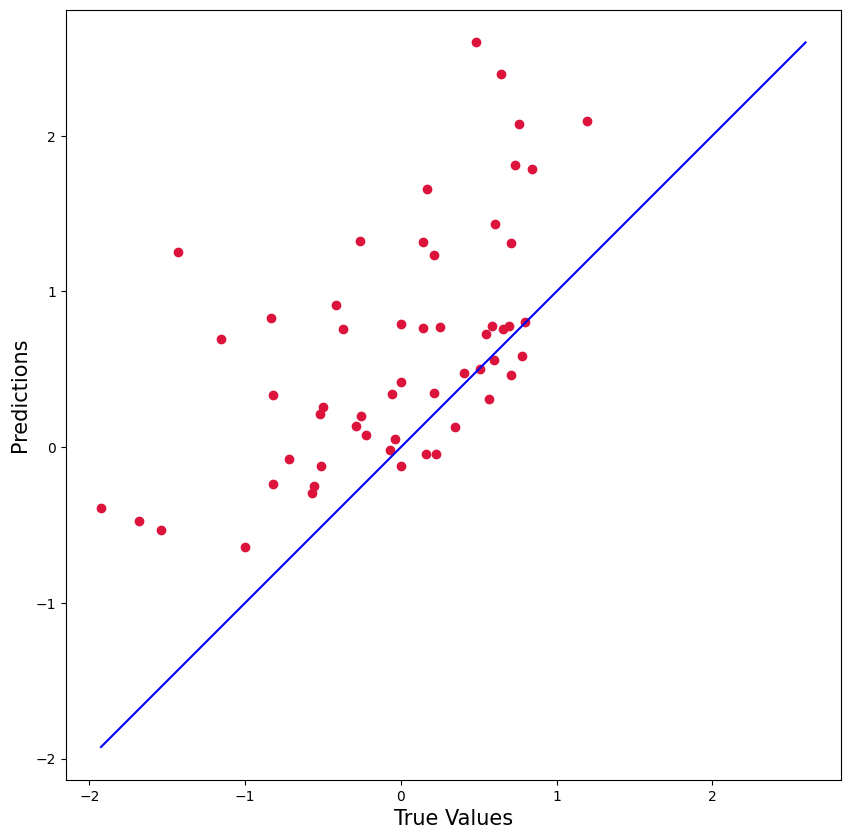

rf 0.6486291486291488


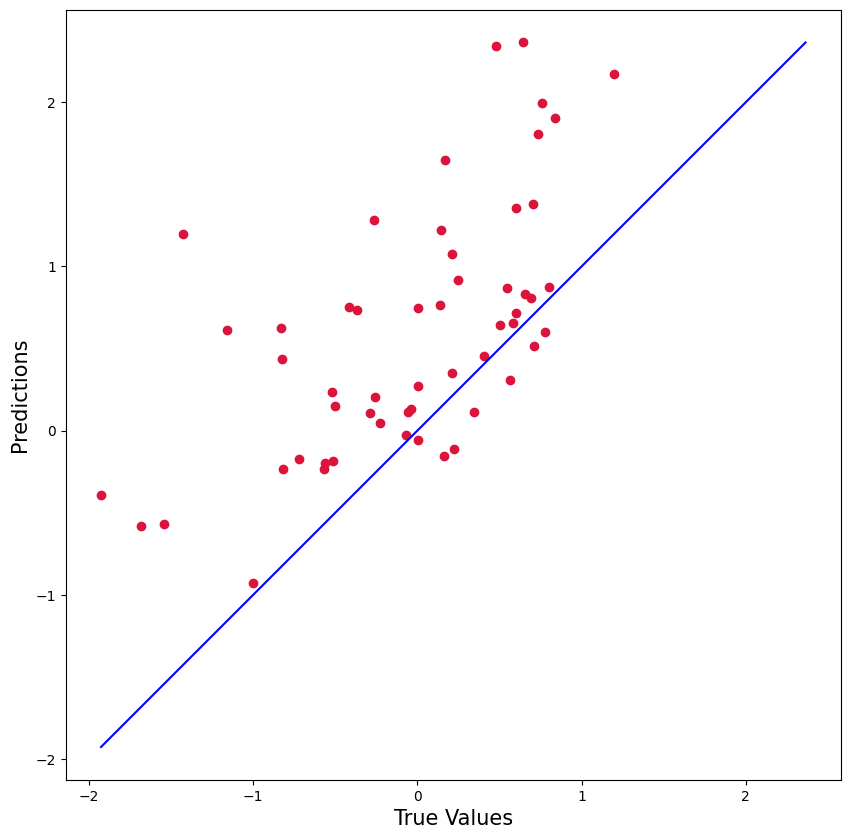

rf 0.6183982683982685


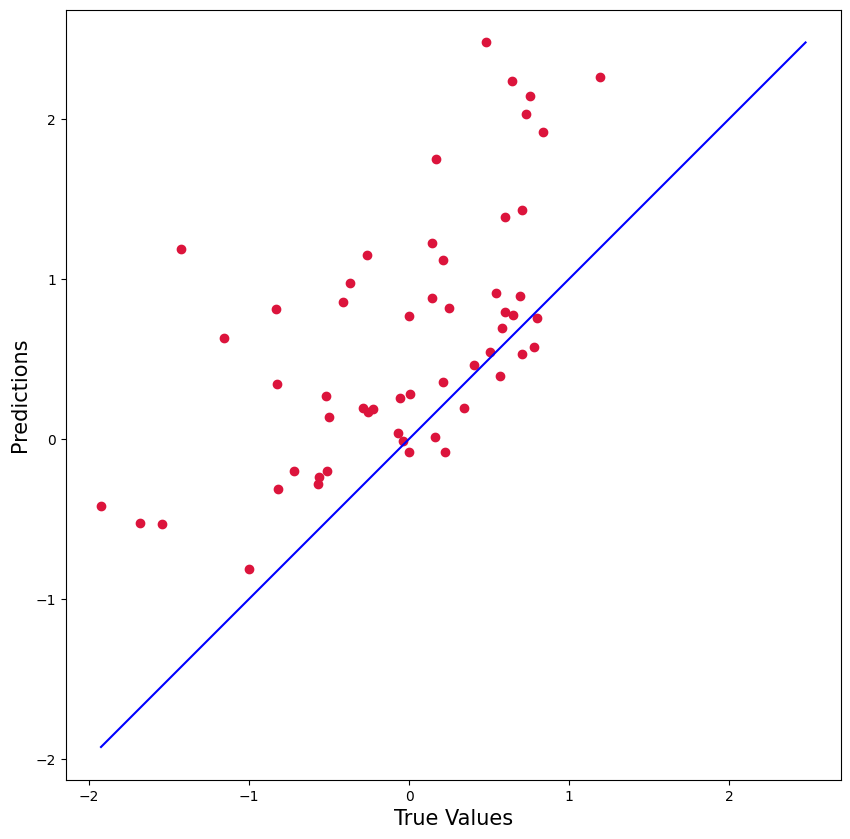

rf 0.6121212121212123


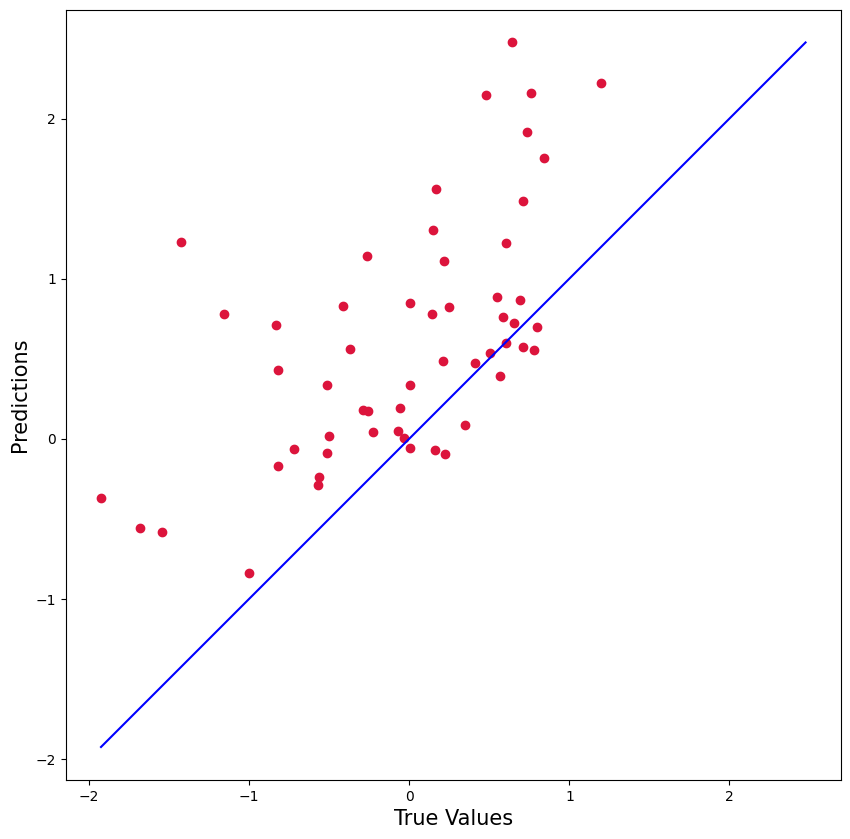

rf 0.6327561327561328


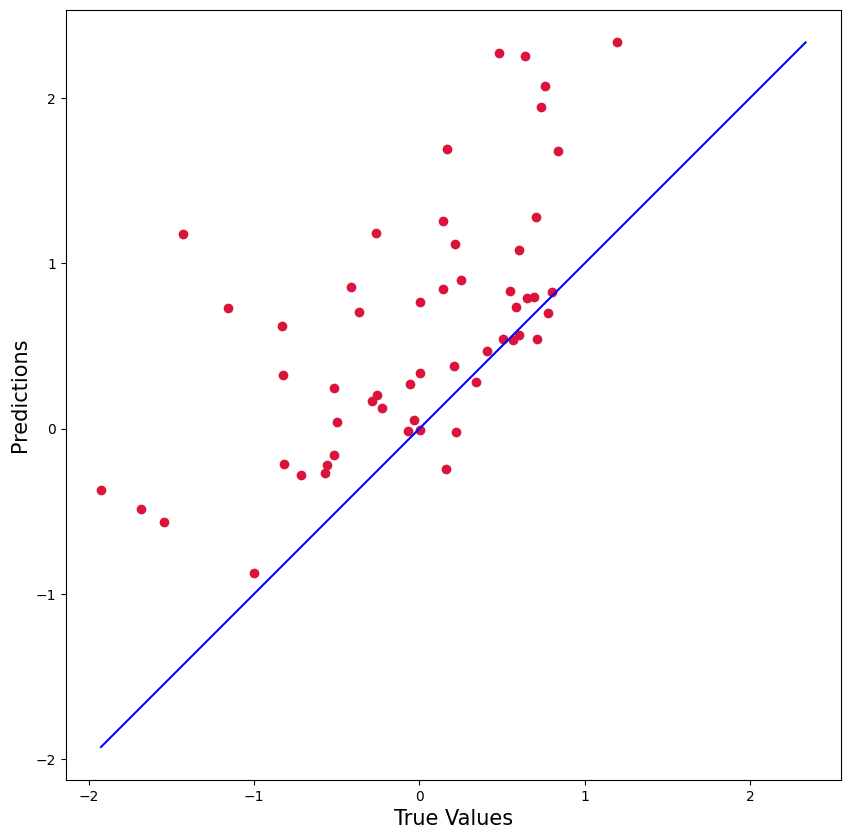

rf 0.6523809523809525


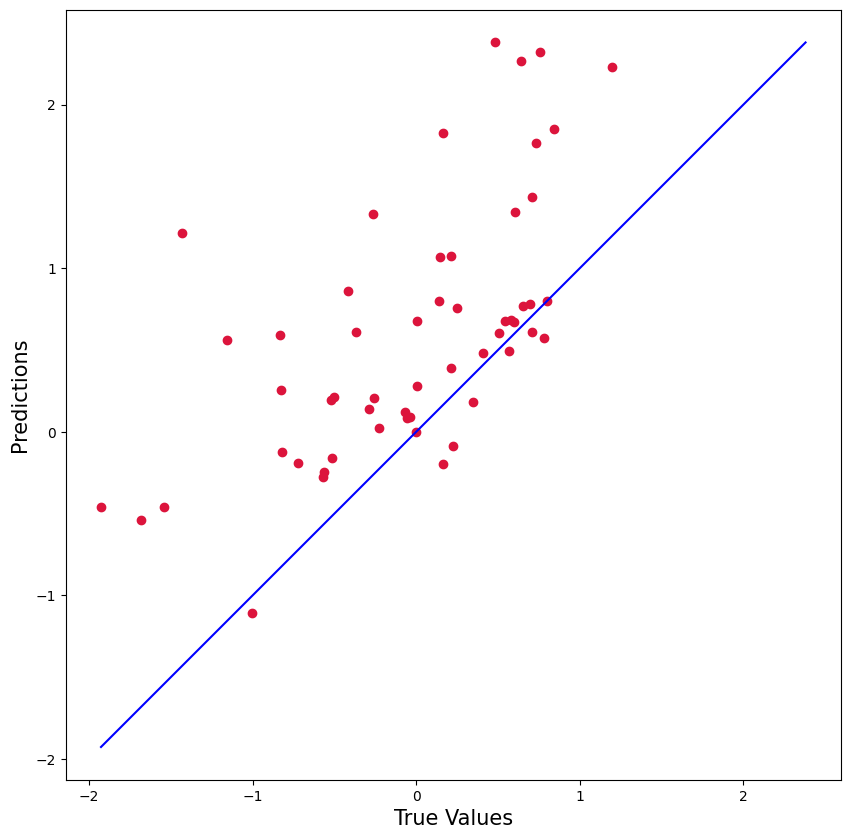

rf 0.6015151515151517


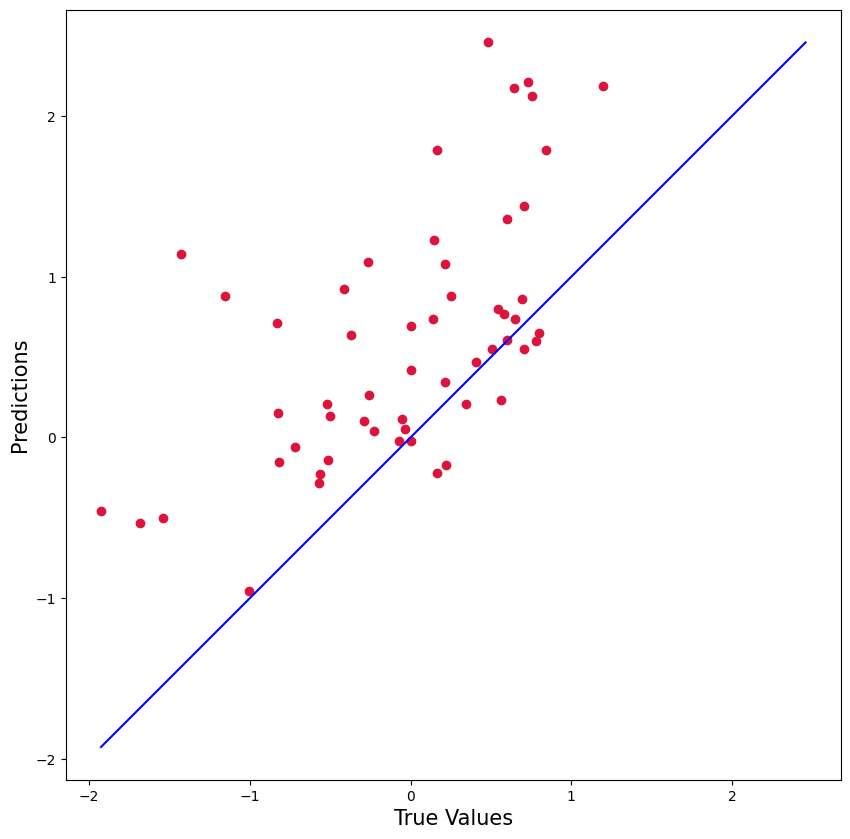

rf 0.6082251082251083


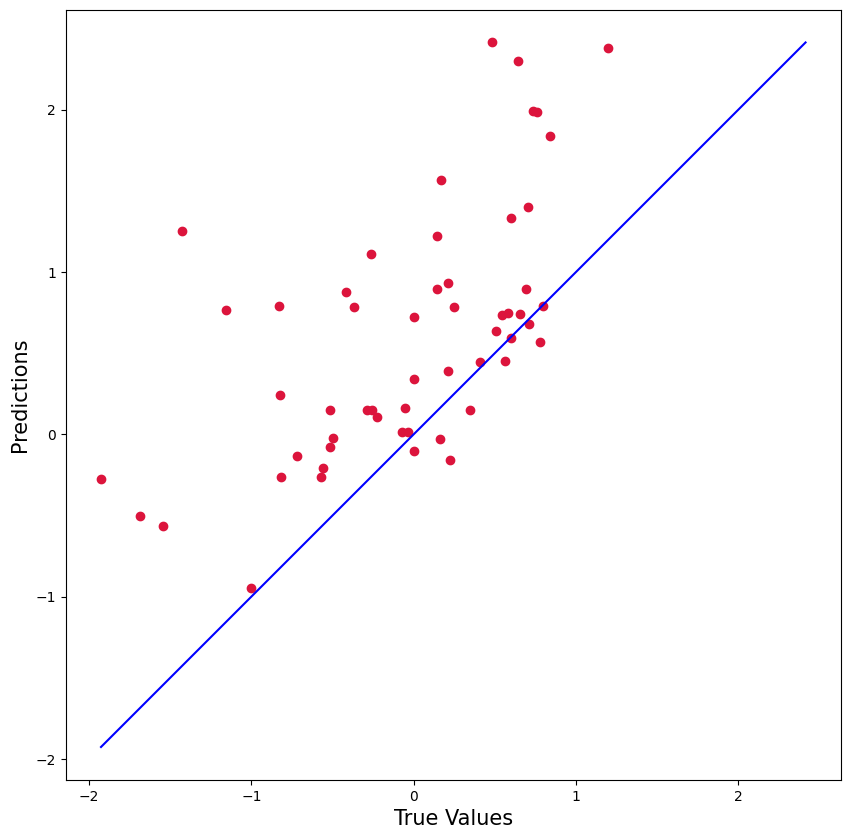

rf 0.6034632034632036


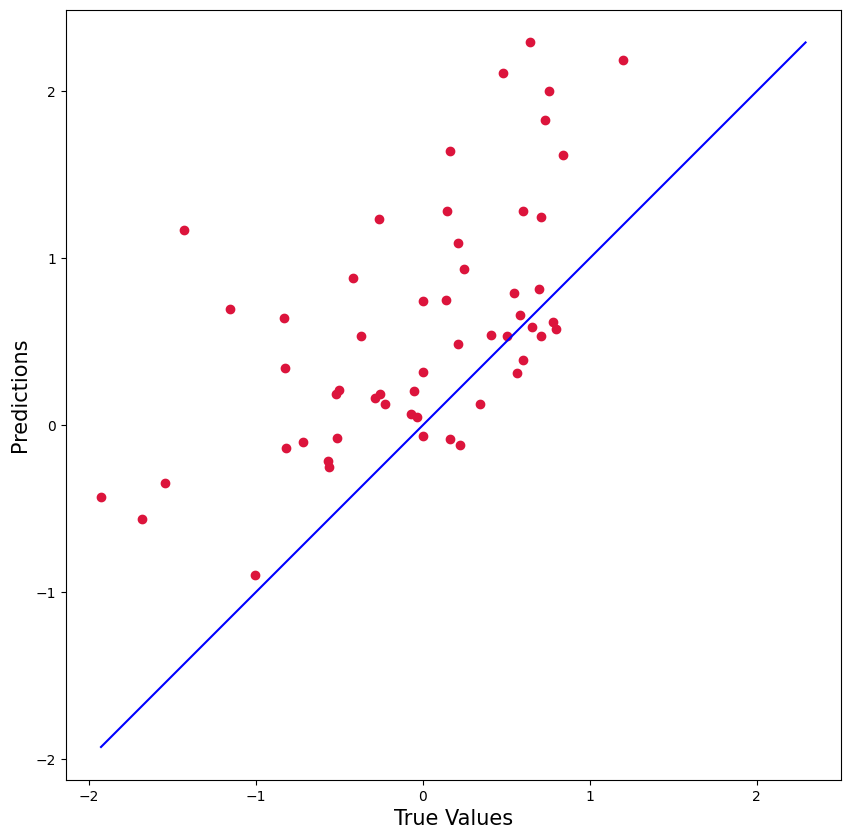

rf 0.6311688311688313


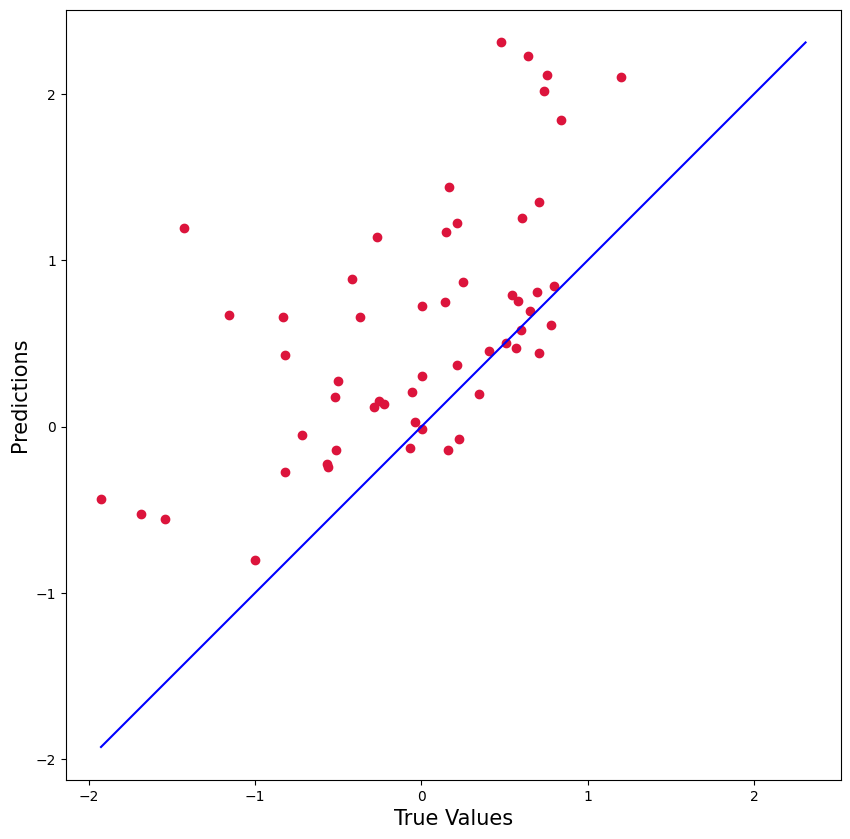

rf 0.6018759018759019


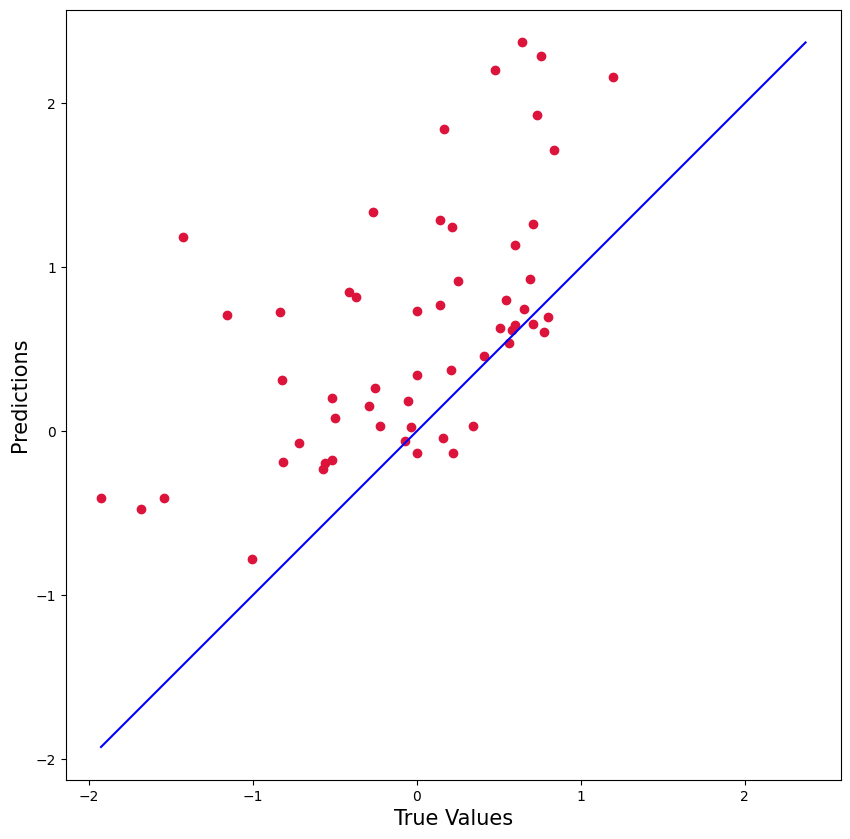

rf 0.627849927849928


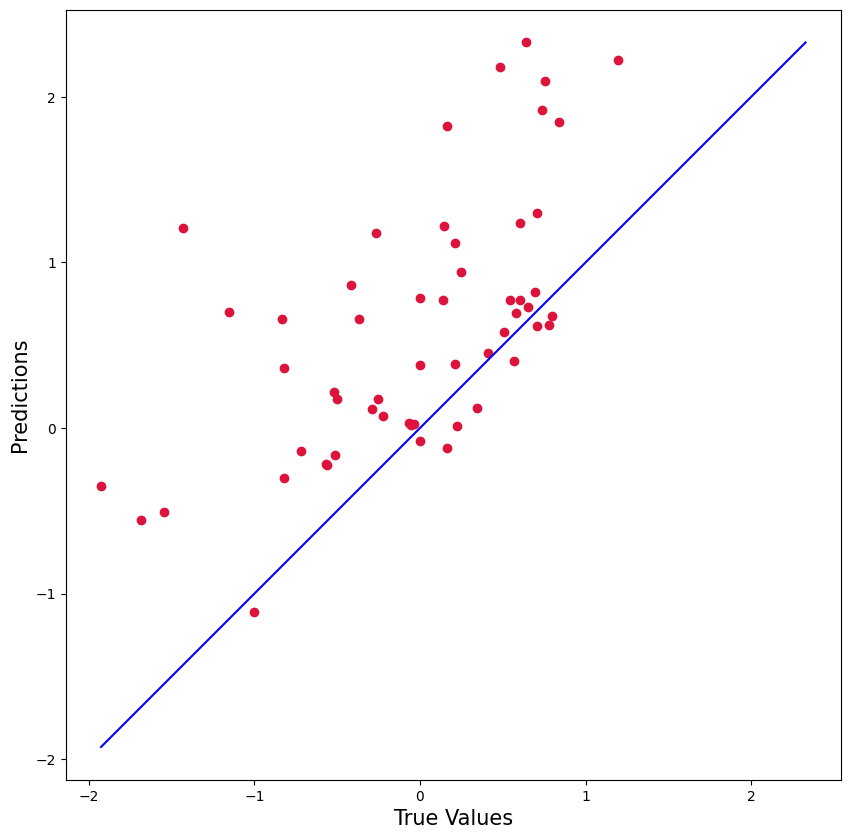

rf 0.6365079365079366


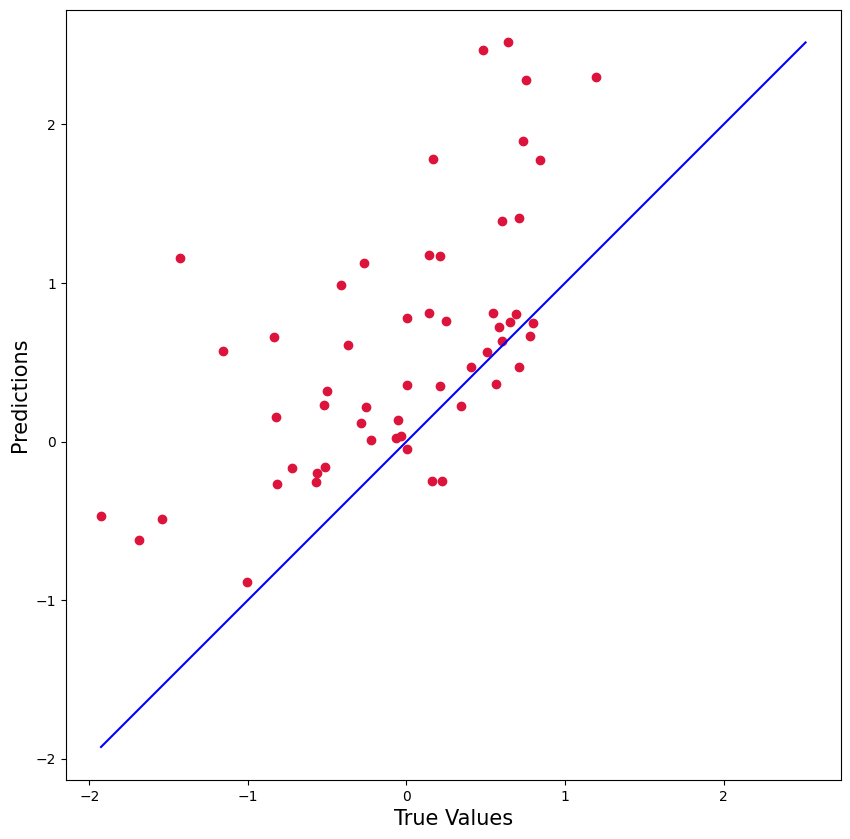

rf 0.6306637806637807


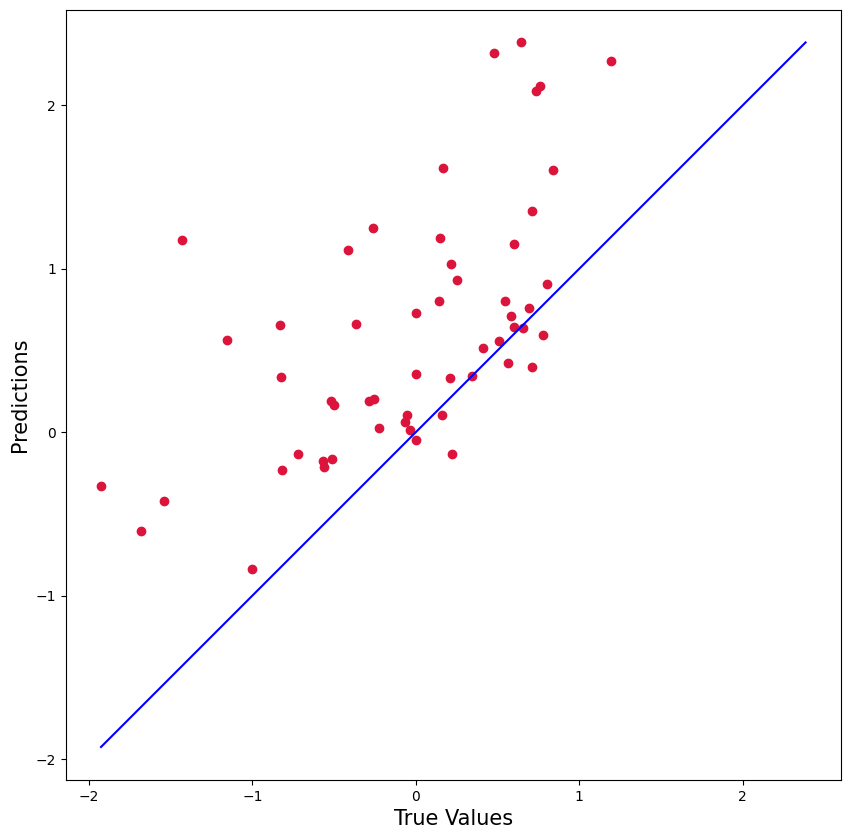

rf 0.6275613275613278


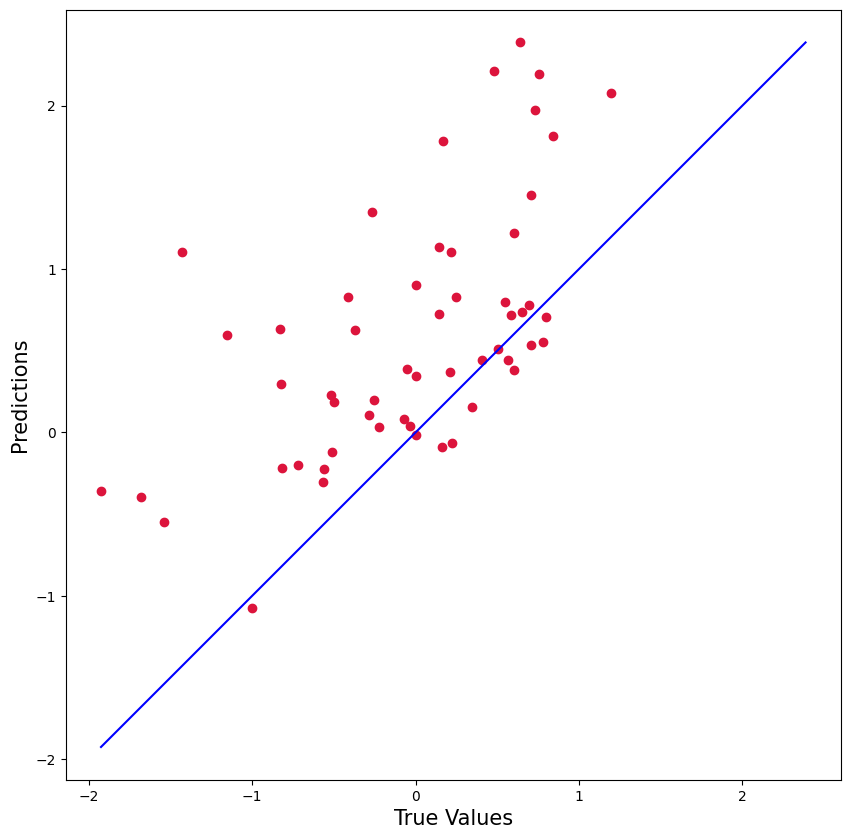

rf 0.6240259740259742


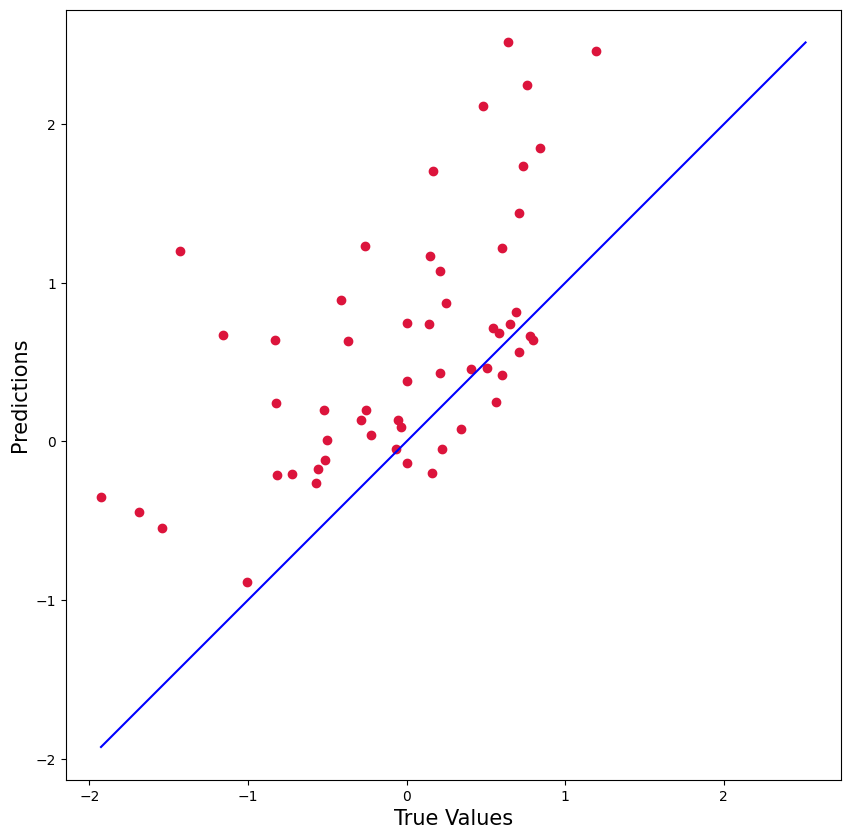

rf 0.6385281385281387


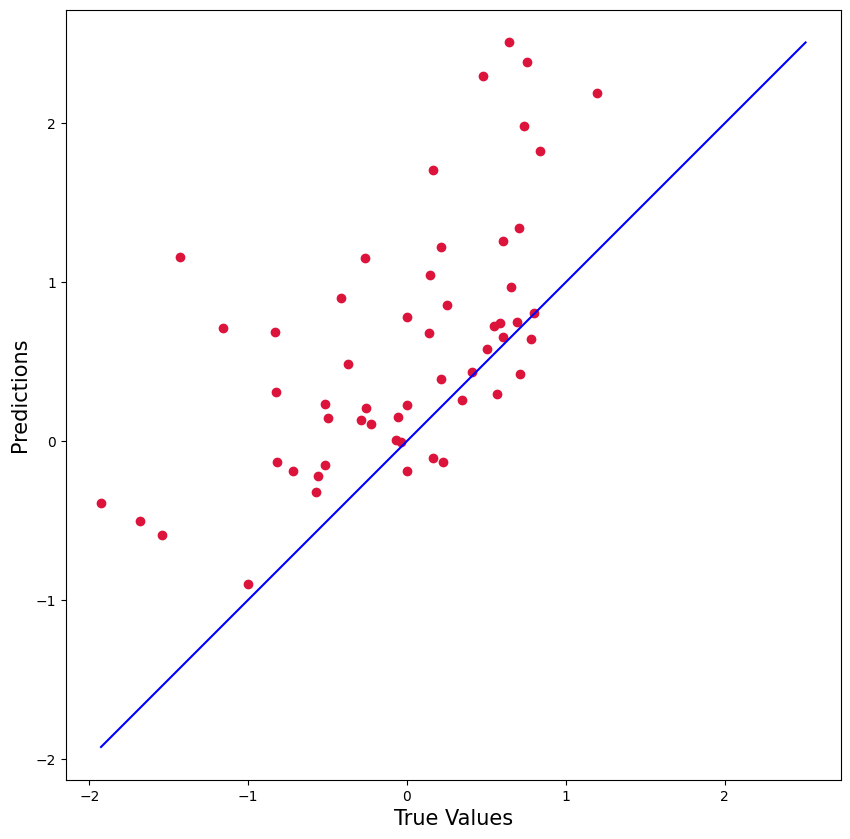

rf 0.6276334776334778


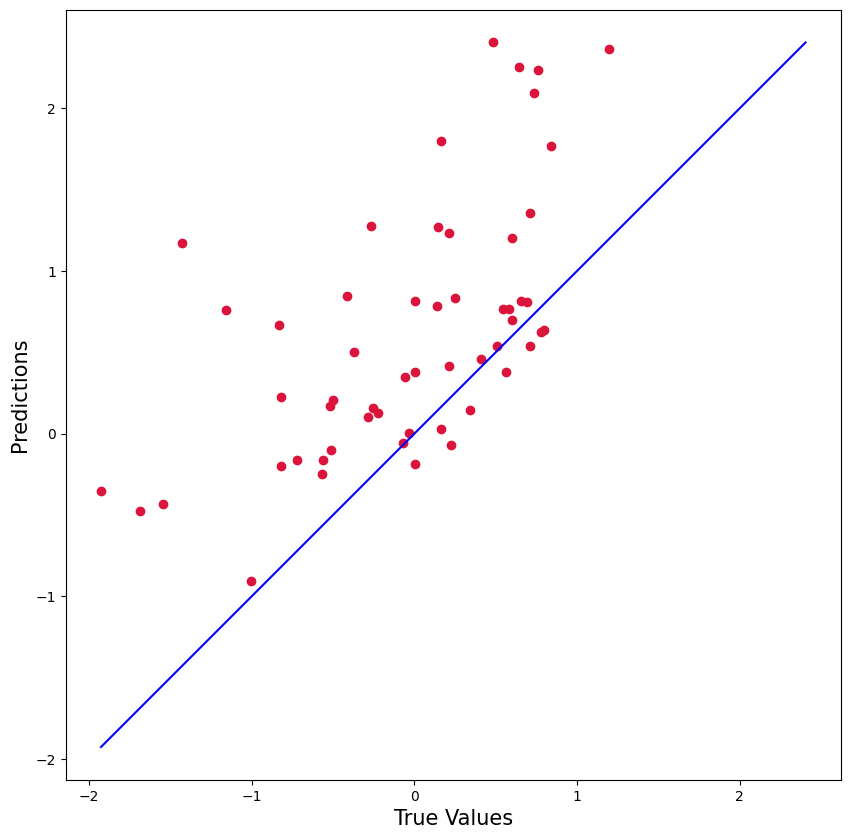

rf 0.6370851370851373


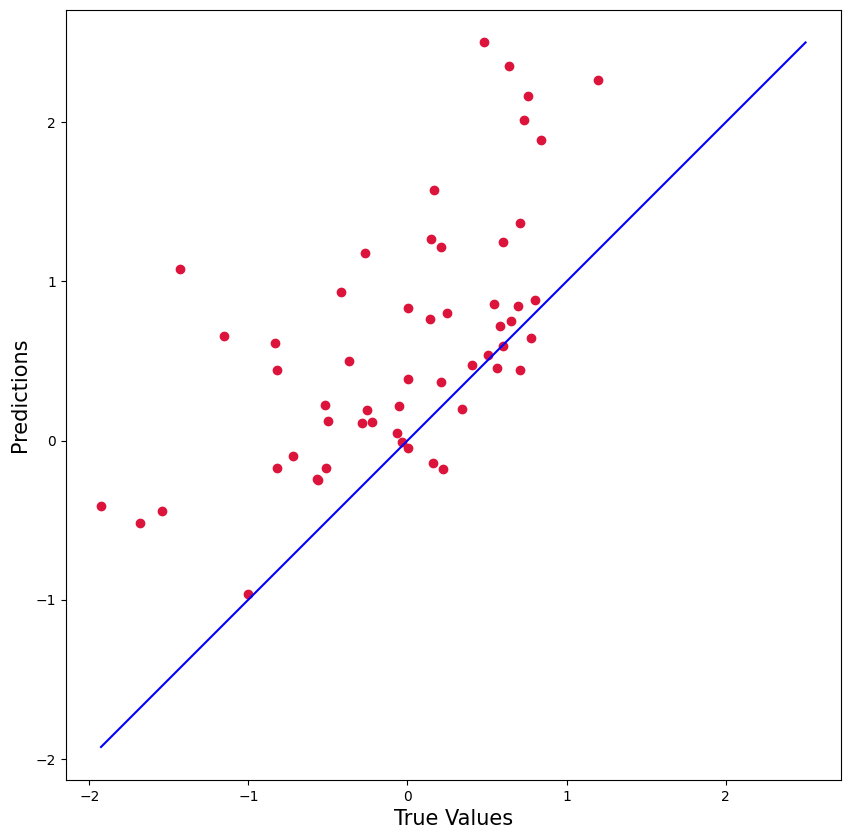

rf 0.6259740259740261


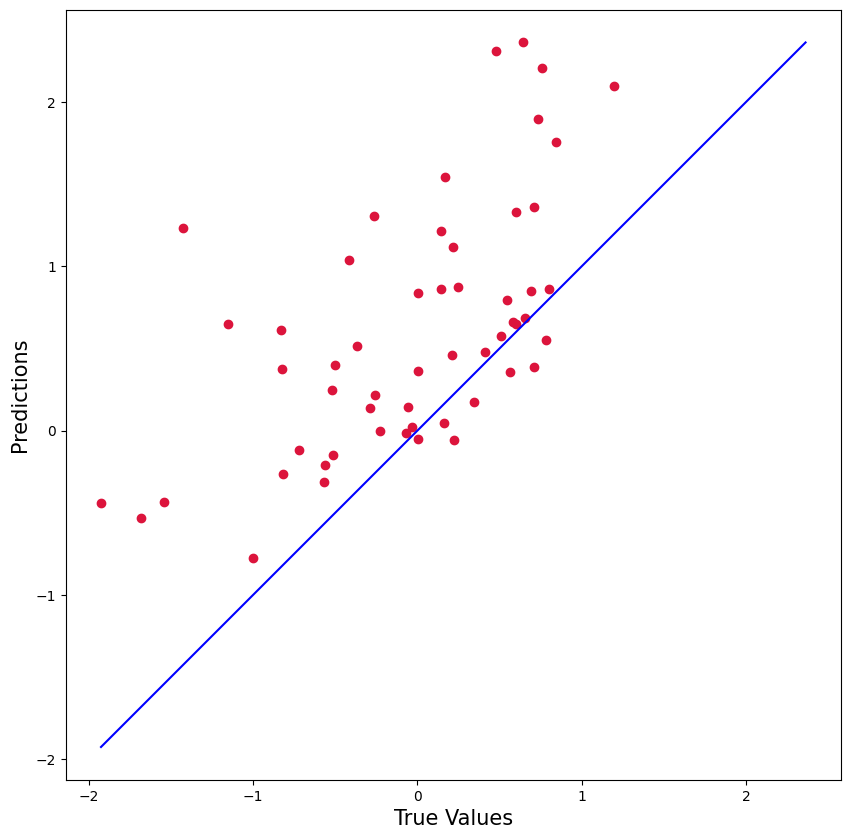

rf 0.6284992784992787


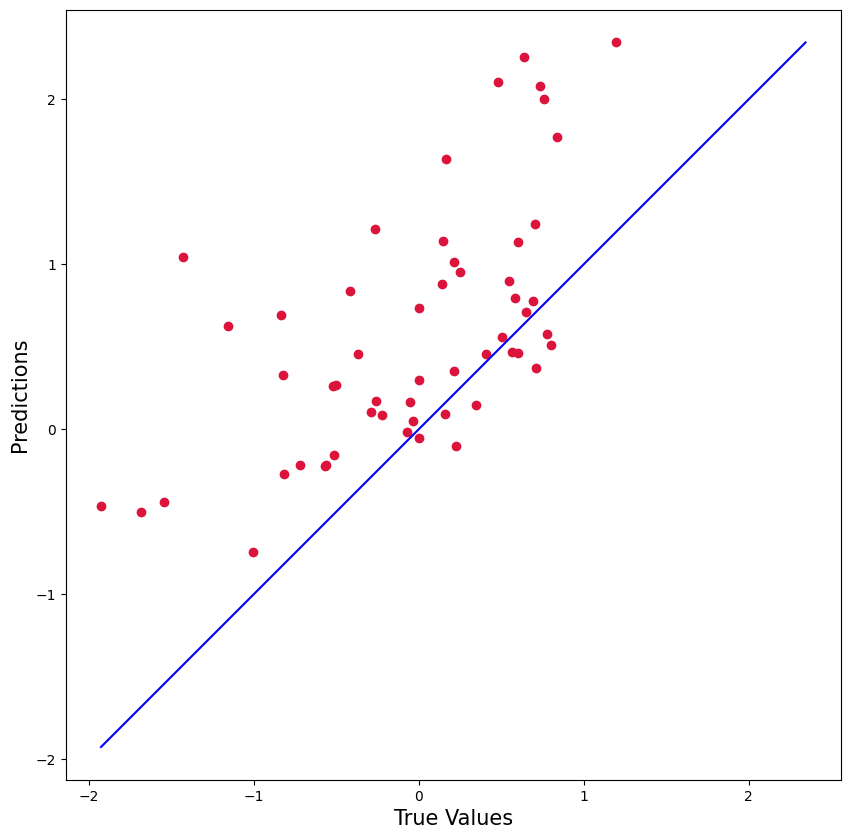

rf 0.6317460317460319


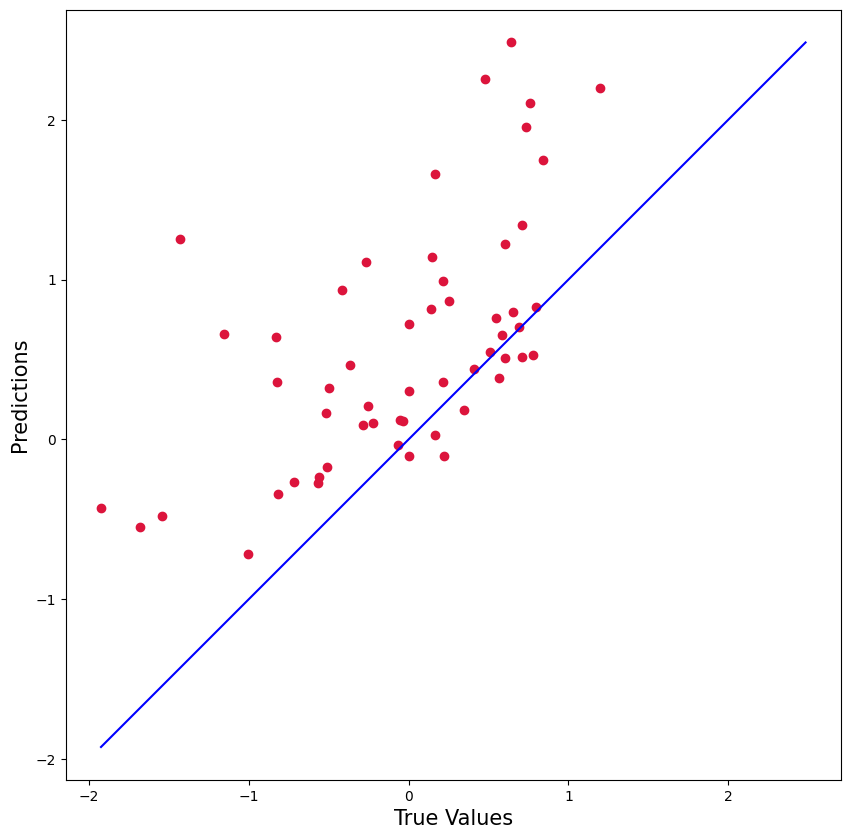

rf 0.6294372294372296


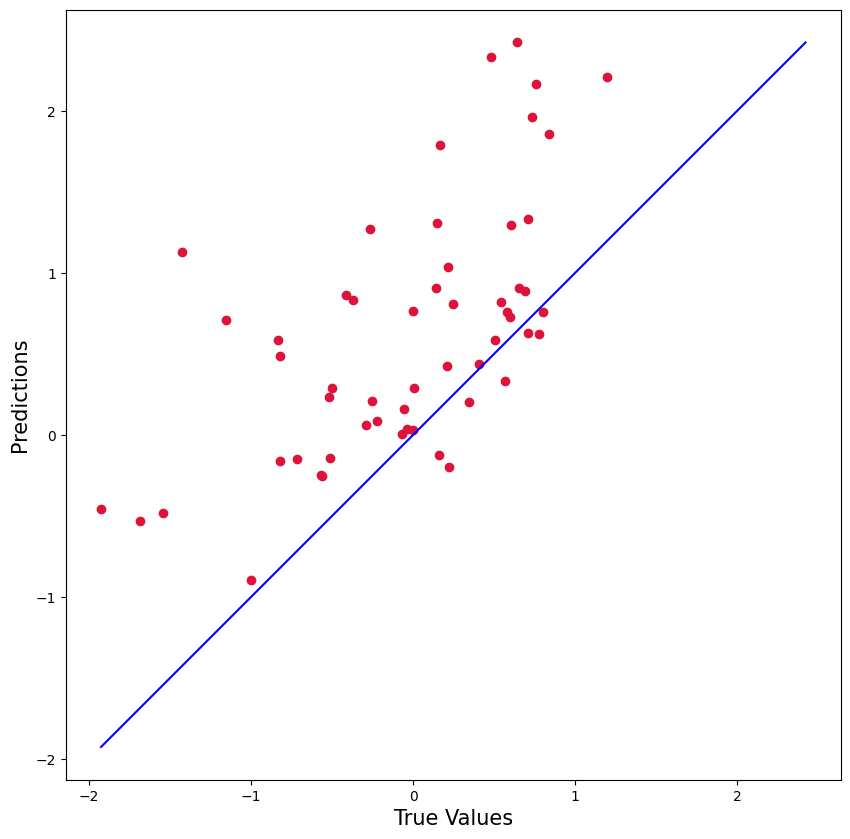

rf 0.6092352092352094


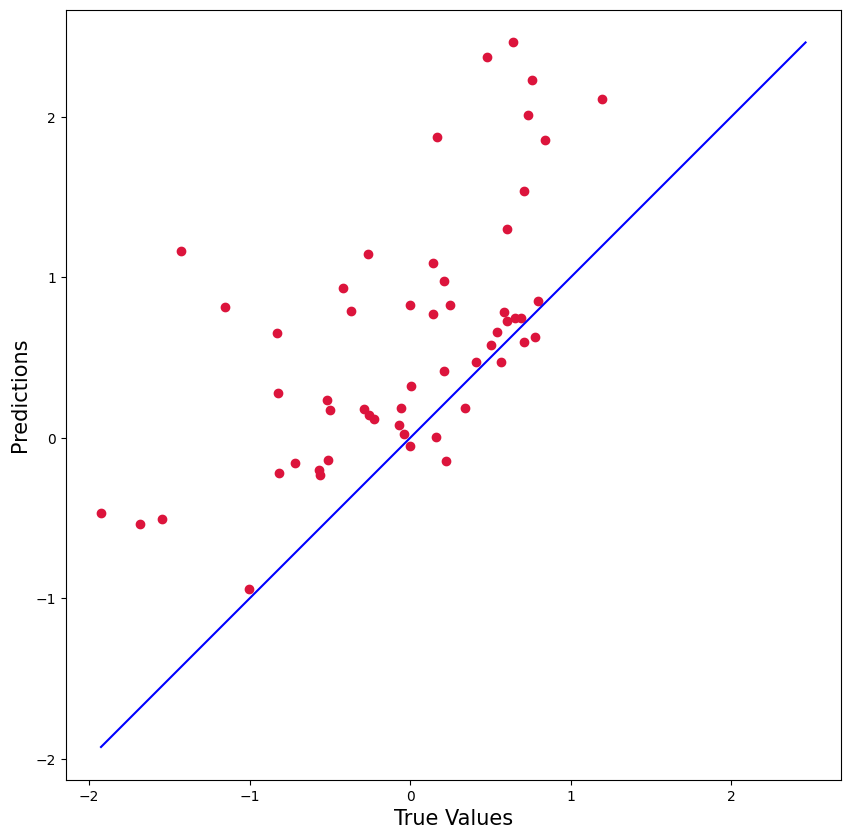

rf 0.606926406926407


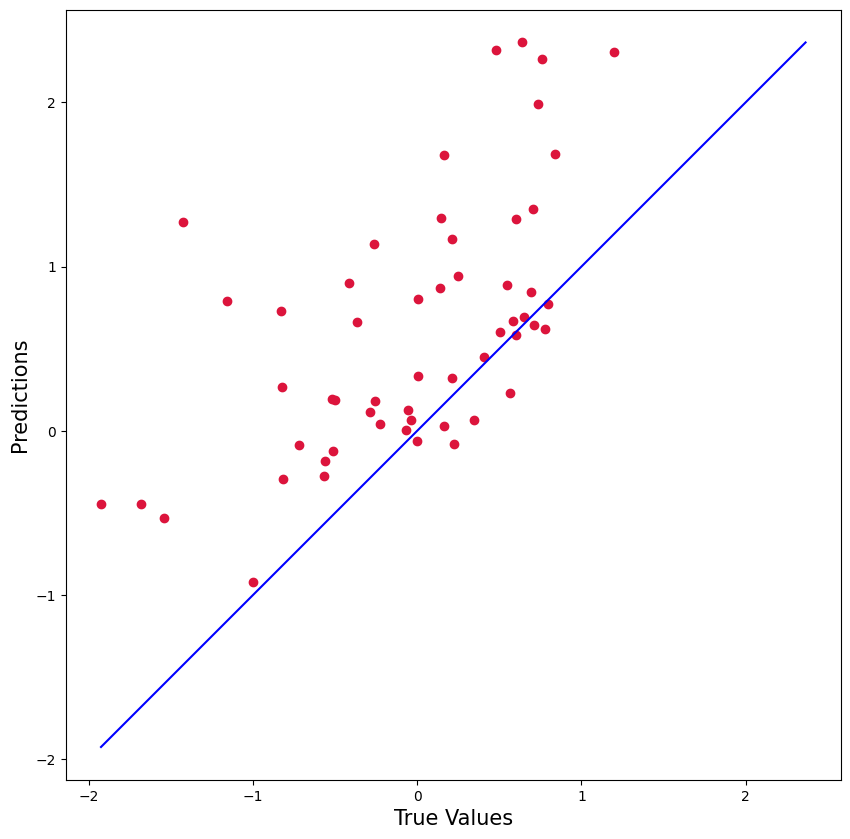

In [54]:
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
spearman={}
spearman['rf']=[]
spearman['rfet']=[]
spearman['xgb']=[]
spearman['svm']=[]
spearman['combined']=[]
pvalue=[]
for i in range(25):
  regr_rf = RandomForestRegressor()
  regr_rf.fit(X_train,y_train)
  ptest = regr_rf.predict(X_test)
  spear, pval = spearmanr(y_test,ptest)
  spearman['rf'].append(spear)
  pvalue.append(pval)
  print("rf",spear)

  # regr_et = ExtraTreesRegressor(n_estimators=500)
  # regr_et.fit(X_train,y_train)
  # ptest = regr_et.predict(X_test)
  # spear, pval = spearmanr(y_test,ptest)
  # spearman['rfet'].append(spear)

  # regr_xgb = xgb.XGBRegressor(objective="reg:linear")
  # regr_xgb.fit(X_train,y_train)
  # ptest = regr_xgb.predict(X_test)
  # spear, pval = spearmanr(y_test,ptest)
  # spearman['xgb'].append(spear)
  # pvalue.append(pval)
  # print("XG",spear)

  # regr_svm = SVR(kernel='rbf',gamma='scale')
  # regr_svm.fit(X_train,y_train)
  # ptest = regr_svm.predict(X_test)
  # spear, pval = spearmanr(y_test,ptest)
  # spearman['svm'].append(spear)


  plot(y_test,ptest)
# for key,value in spearman.items():
#   spearman[key]=np.array(value)
#   print(key)
#   print(round(spearman.key.mean(),2), ' +/- ', round(spearman,key.std(),2))
#   print((pvalue<0.05).sum())

# pvalue = np.array(pvalue)
# print(spearman)
# print(round(spearman.mean(),2), ' +/- ', round(spearman.std(),2))
# print((pvalue<0.05).sum())


In [55]:
for key,value in spearman.items():
  spearman[key]=np.array(value)
  print(key)
  print(round(spearman[key].mean(),2), ' +/- ', round(spearman[key].std(),2))

# for value in pvalue:
#   print(round(value.mean(),2), ' +/- ', round(value.std(),2))

rf
0.62  +/-  0.01
rfet
nan  +/-  nan
xgb
nan  +/-  nan
svm
nan  +/-  nan
combined
nan  +/-  nan


<ipython-input-55-9d6664bc4e0f>:4: RuntimeWarning: Mean of empty slice.
  print(round(spearman[key].mean(),2), ' +/- ', round(spearman[key].std(),2))
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**CNN for training, incomplete**

In [77]:
def model_init():
  model = keras.Sequential([
  keras.Input(shape=(2842,)),
  keras.layers.Dense(4096),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dense(1024),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dense(256),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dense(64),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  # keras.layers.Dense(32),
  # keras.layers.BatchNormalization(),
  # keras.layers.Activation('relu'),
  keras.layers.Dense(16),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  # keras.layers.Dense(8),
  # keras.layers.BatchNormalization(),
  # keras.layers.Activation('relu'),
  keras.layers.Dense(4),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(1),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('sigmoid'),
])
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-1,
      decay_steps=1000,
      decay_rate=0.95)
  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

  model.compile(optimizer=optimizer,
              # loss=focal_loss_custom(alpha=0.2, gamma=2.0),
              loss=keras.losses.MeanSquaredError(),
              )
  model.summary()
  return model





In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(64, input_shape=(2842,)))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 4096)              11644928  
                                                                 
 batch_normalization_42 (Ba  (None, 4096)              16384     
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 4096)              0         
                                                                 
 dense_46 (Dense)            (None, 1024)              4195328   
                                                                 
 batch_normalization_43 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 activation_37 (Activation)  (None, 1024)            

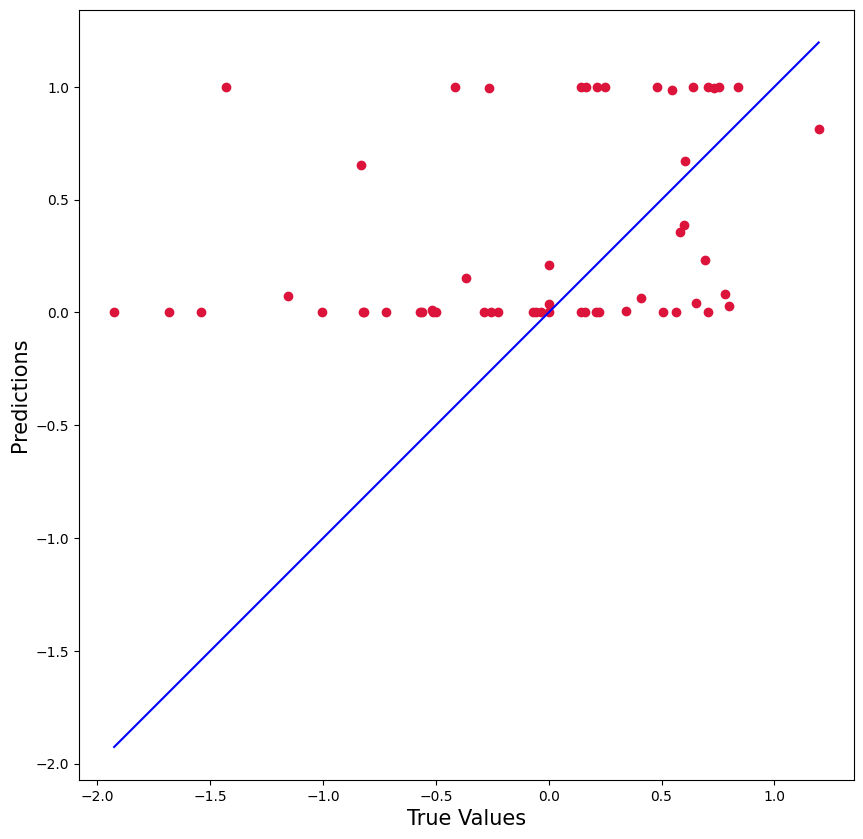

0.4987012987012988


In [78]:

Xtrain, X_val, ytrain, y_val = train_test_split(X_train, y_train, test_size=0.2)
model=model_init()
history = model.fit(Xtrain, ytrain,
                          epochs = 100,
                          validation_data=(X_val,y_val),
                          shuffle=True)
y_pred = model.predict(X_test)
y_pred.reshape(-1)
plot(y_test,y_pred)
res = spearmanr(y_pred, y_test)
print(res.statistic)

In [79]:
y_pred.reshape(-1)

array([3.6362599e-04, 2.6023781e-03, 7.2852455e-02, 9.9972618e-01,
       8.1156313e-01, 1.1586312e-06, 9.9972343e-01, 9.9500829e-01,
       9.9622411e-01, 9.8625332e-01, 2.2003044e-06, 4.7038375e-07,
       2.8648457e-04, 1.4976619e-06, 1.0182424e-04, 3.8839063e-01,
       2.3201378e-06, 3.2015460e-06, 1.3626538e-07, 9.3140663e-04,
       6.7101181e-03, 8.5396533e-07, 3.5911489e-02, 2.8879678e-02,
       1.1346414e-06, 1.9828117e-04, 4.5573333e-07, 1.5236269e-01,
       9.0429618e-05, 2.3176420e-01, 6.7215353e-01, 8.3306924e-02,
       2.1155731e-01, 3.5525176e-01, 9.9958408e-01, 1.1214981e-03,
       9.9981815e-01, 9.9792284e-01, 9.9968249e-01, 4.8643669e-06,
       5.0092401e-04, 9.9971461e-01, 2.3791547e-06, 9.1190955e-08,
       5.5744984e-08, 9.9953783e-01, 6.1924502e-02, 6.5339553e-01,
       9.9960029e-01, 4.4021819e-02, 9.9967134e-01, 9.9973440e-01,
       1.1373960e-02, 2.2450124e-07, 4.0185678e-05], dtype=float32)

In [80]:
from scipy.stats import stats
res = stats.spearmanr(y_pred, y_test)
print(res.statistic)

0.4987012987012988


<ipython-input-80-9d9a467cbe06>:2: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  res = stats.spearmanr(y_pred, y_test)


In [81]:
len(y_pred)

55

In [82]:
len(X_test)

55

In [83]:
y_train

array([ 1.3735    ,  2.7295    , -0.024     , -0.326     ,  1.4335    ,
       -0.5495    ,  0.734     ,  2.17      ,  0.662     ,  0.7145    ,
       -0.4155    ,  0.5415    ,  1.0995    ,  2.215     ,  0.7785    ,
        0.5325    , -0.3415    ,  1.056     ,  0.769     ,  1.0565    ,
        0.1665    ,  0.0975    , -0.766     ,  0.2985    ,  3.0675    ,
        3.048     ,  2.0255    ,  2.886     , -0.329     ,  1.121     ,
        2.308     , -0.0315    ,  1.51      ,  0.19      ,  0.834     ,
        2.2465    , -0.722     , -0.7355    , -0.817     ,  1.939     ,
        3.248     ,  4.394     ,  2.706     ,  1.2535    ,  1.213     ,
        0.244     , -0.1235    , -0.6835    ,  3.377     ,  2.698     ,
        0.081     ,  2.1455    ,  1.403     ,  0.951     ,  1.1475    ,
        4.2195    , -0.01      ,  0.235     ,  1.7135    ,  0.7745    ,
        0.6715    ,  3.514     ,  4.256     ,  2.907     , -0.469     ,
        0.5725    , -0.173     , -1.368     ,  0.442     ,  3.93

In [84]:

mask=torch.tensor(y_train)<0
y_train_binary=torch.zeros_like(torch.tensor(y_train))
y_train_binary[mask]=1
y_train_binary.tolist()

mask=torch.tensor(y_test)<0
y_test_binary=torch.zeros_like(torch.tensor(y_test))
y_test_binary[mask]=1
y_test_binary.tolist()

[1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0]

In [85]:
y_train_binary

tensor([0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 

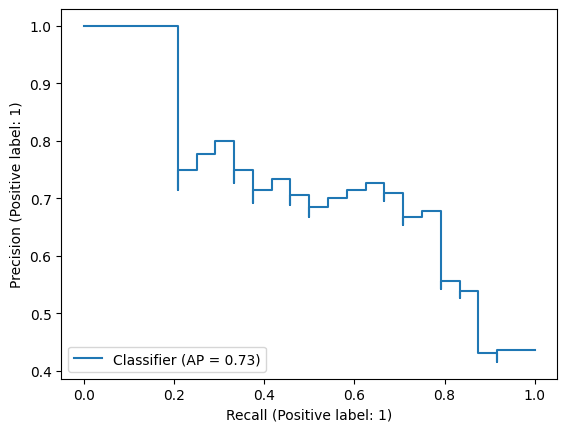

In [86]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train_binary)
y_pred = classifier.predict_proba(X_test)[:, 1]


# np.save(iter_path, y_pred)
PrecisionRecallDisplay.from_predictions(y_test_binary,y_pred)
plt.show()

In [87]:
y_pred

array([0.39738095, 0.69333333, 0.18766667, 0.05      , 0.04355556,
       0.63333333, 0.02      , 0.06416667, 0.06588889, 0.16657937,
       0.49616667, 0.9375    , 0.3725    , 0.43738095, 0.08      ,
       0.25916667, 0.52366667, 0.44066667, 0.54683333, 0.47333333,
       0.57983333, 0.96166667, 0.49478571, 0.537     , 0.94      ,
       0.46016667, 0.48580952, 0.23716667, 0.38333333, 0.055     ,
       0.13466667, 0.04166667, 0.01      , 0.095     , 0.04      ,
       0.045     , 0.03      , 0.086     , 0.02      , 0.75966667,
       0.0215    , 0.0375    , 0.62430952, 0.63846032, 0.6622619 ,
       0.06      , 0.00333333, 0.        , 0.02      , 0.02      ,
       0.02      , 0.1       , 0.        , 0.97      , 0.37975397])

In [89]:
# combine features of two drugs
# binarilize the features using best threshold
# sigma score: add together
# delta: add together, 1+1=0
# concatenate sigma+delta
# don't binarilize scores
# spiersman corr
test.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.pkl"))
train.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_train_feat.pkl"))

In [92]:
test = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.csv"))
test

FileNotFoundError: ignored